In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import fitsio
from astropy.coordinates import SkyCoord
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import construct_templates, compute_Cells_from_map, compute_Cells
import dipole
from jackknife import get_longitude_subsamples, compute_jackknife_uncertainty

### FITTING FUNCTION

In [3]:
def Cells_from_alms_fit(datamap, Cinv, max_ell, idx_to_fit=None, return_alms=False):
    """
    Performs a linear least-squares fit to a healpix density map to get best-fit spherical harmonic amplitudes alm.
    Regularize by setting masked pixels (NaN or hp.UNSEEN) to zero counts and assuming `Cinv=1`.
    Returns the Cells as computed from the alms (sum of |alms|^2).
    
    """
    assert datamap.shape == Cinv.shape
    assert datamap.ndim == Cinv.ndim == 1
    
    # get number of pixels from input data map
    NPIX = len(datamap)
    
    # construct Ylm templates -> design matrix
    ells = np.arange(0, max_ell+1)
    templates = construct_templates(ells, hp.npix2nside(NPIX))
    A = templates.T
    
    # indices to fit: non-NaN, non-hp.UNSEEN, non-zero
    if idx_to_fit is None:
        idx_to_fit = np.full(NPIX, True).astype(bool)
    else:
        idx_to_fit = idx_to_fit
    idx_to_fit = idx_to_fit & (datamap != 0) & (~np.isnan(datamap)) & (datamap != hp.UNSEEN)
    map_to_fit, A_fit, Cinv_fit = datamap.copy(), A.copy(), Cinv.copy()
    
    # # regularization: set masked data to 0 and variance in masked pixels to 1
    # map_to_fit[~idx_to_fit] = 0
    # Cinv_fit[~idx_to_fit] = 1.
    
    # perform the regression: bestfit_pars are the alms
    bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)
    Cells = compute_Cells(bestfit_pars)
    
    if return_alms == True:
        return ells, Cells, bestfit_pars
    else:
        return ells, Cells

In [4]:
def reconstruct_map(alms, NSIDE=64):
    """
    Reconstruct a healpix map from a list of spherical harmonic coefficients a_lm.
    
    """
    # iterative over ells to correctly assign the alms to their respective multipoles
    reconstructed_map = np.zeros(hp.nside2npix(NSIDE))
    ell = 0
    i1 = 0  # this will give us the starting index to pull from amps for each ell
    while i1 < len(alms):
        i2 = i1 + 2 * ell + 1  # stopping index to pull from amps
        assert i2 <= len(alms)  # make sure we aren't trying to pull more amplitudes than we input!
        # construct the 2ell+1 templates
        ells = np.arange(ell+1)
        templates = construct_templates(ells, NSIDE=NSIDE)
        # add the map for this ell to the overall reconstructed map
        map_thisell = np.zeros_like(reconstructed_map)
        for im, alm_ in enumerate(alms[i1:i2]):
            map_thisell += alm_ * templates[i1:i2][im]
        reconstructed_map += map_thisell
        ell += 1
        i1 = i2
        
    return reconstructed_map

### load samples

In [5]:
NSIDE = 64  # healpix resolution

In [6]:
# CatWISE overdensity map

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                    blim=30, maglim=16.4, save_tag='_r1.0', load_init=True)
d = SecrestDipole(**catwise_kwargs)
d.cut_mag()
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)

# delete the tables to clear up memory !
del d.initial_cattab
del d.table

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

# GET OVERDENSITIES
overdensity_map_catwise = masked_datamap / np.nanmean(masked_datamap) - 1

loading initial catalog, catwise_agns_master.fits
8532854 sources in initial catalog.
cut w1 > 16.4 -> 3079981 sources left.


In [7]:
# Quaia overdensity map

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False)
d = SecrestDipole(**quaia_kwargs)
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)
mean, std = np.nanmean(datamap), np.nanstd(datamap)

# and load selection function
selfunc = d.load_selfunc()

# delete the tables to clear up memory !
del d.initial_cattab
del d.table

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# also mask any completeness < 0.5
mask = mask & (selfunc > 0.5)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

# GET OVERDENSITIES
# mean density of the map: mean of the _expected_ counts
mean_density = np.nanmean(masked_datamap[selfunc>0] / selfunc[selfunc>0])

# then the overdensity map is
overdensity_map_quaia = np.divide(masked_datamap, selfunc, where=(selfunc>0),
                            out=np.full_like(masked_datamap, np.nan)) / mean_density - 1
                    # (fancy divide to avoid RuntimeWarnings where completeness goes to zero)

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.


### fit only the dipole ($\ell=1$) with the usual Secrest/EB definition and function
#### $\rightarrow$ look at impact of variance of the masked pixels

In [8]:
# plot dipole templates
templates = construct_templates([0,1], hp.npix2nside(len(overdensity_map_catwise)))

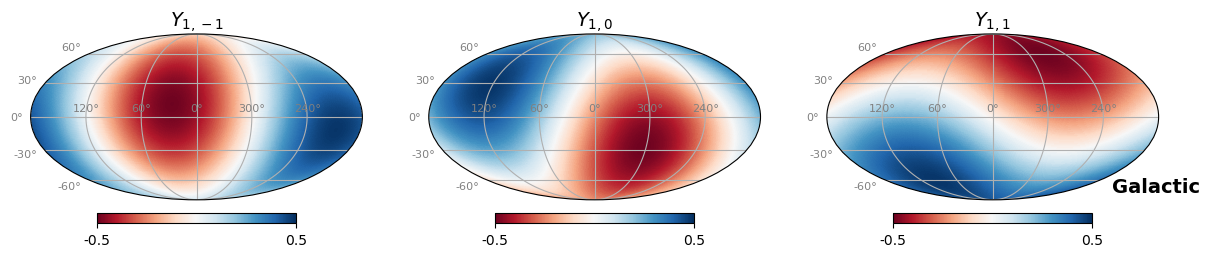

In [9]:
fig = plt.figure(figsize=(12,3))

titles = [r'$Y_{1,-1}$', r'$Y_{1,0}$', r'$Y_{1,1}$']
for i, template in enumerate(templates[1:]):
    hp.projview(template, sub=(1,3,i+1), title=titles[i], min=-0.5, max=0.5, coord=['C','G'], fig=fig, cmap='RdBu',
              graticule=True, graticule_labels=True, xtick_label_color='grey', ytick_label_color='grey',
             fontsize={'xtick_label':8, 'ytick_label':8})
    if i == len(titles)-1:
        tools.label_coord(plt.gca(), 'Galactic')

In [10]:
# expected amplitudes from EB84
cmb_dipamp_catwise = 0.007
cmb_dipamp_quaia = 0.005

In [11]:
# get the two main cases: 1) don't fit masked pixels at all, and 2) set masked pixels to zero with Cinv=1

# CATWISE
print("CATWISE")
# Cinv=identity, fit_zeros=False
print("fit_zeros = False:")
map_to_fit = overdensity_map_catwise.copy()
map_to_fit[np.isnan(map_to_fit)] = 0.
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=np.ones_like(map_to_fit), fit_zeros=False)
print(f"\tamps: {amps}\n\tbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"\texpected dipole amp. =\t{cmb_dipamp_catwise:.5f}\n\tratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_catwise:.4f}")
dipamp_catwise_noreg = np.linalg.norm(amps[1:])

# Cinv=identity, fit_zeros=True
print("fit_zeros = True:")
map_to_fit = overdensity_map_catwise.copy()
map_to_fit[np.isnan(map_to_fit)] = 0.
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=np.ones_like(map_to_fit), fit_zeros=True)
print(f"\tamps: {amps}\n\tbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"\texpected dipole amp. =\t{cmb_dipamp_catwise:.5f}\n\tratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_catwise:.4f}")

# QUAIA
print("QUAIA")
# Cinv=selfunc, fit_zeros=False
print("fit_zeros = False:")
map_to_fit = overdensity_map_quaia.copy()
map_to_fit[np.isnan(map_to_fit)] = 0.
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=selfunc.copy(), fit_zeros=False)
print(f"\tamps: {amps}\n\tbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"\texpected dipole amp. =\t{cmb_dipamp_quaia:.5f}\n\tratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_quaia:.4f}")
dipamp_quaia_noreg = np.linalg.norm(amps[1:])

# Cinv=(selfunc in unmasked, 1 in masked), fit_zeros=True
print("fit_zeros = True:")
map_to_fit = overdensity_map_quaia.copy()
idx_masked = np.isnan(map_to_fit)
map_to_fit[idx_masked] = 0.
Cinv = selfunc.copy()
Cinv[idx_masked] = 1
amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv, fit_zeros=True)
print(f"\tamps: {amps}\n\tbest-fit dipole amp. =\t{np.linalg.norm(amps[1:]):.5f}")
print(f"\texpected dipole amp. =\t{cmb_dipamp_quaia:.5f}\n\tratio =\t\t\t{np.linalg.norm(amps[1:])/cmb_dipamp_quaia:.4f}")

CATWISE
fit_zeros = False:
	amps: [ 7.70097306e-05 -1.24867252e-02  1.04018103e-02 -4.40991047e-03]
	best-fit dipole amp. =	0.01684
	expected dipole amp. =	0.00700
	ratio =			2.4056
fit_zeros = True:
	amps: [-4.35851430e-18 -7.04874000e-03  2.39939411e-03  4.78969857e-04]
	best-fit dipole amp. =	0.00746
	expected dipole amp. =	0.00700
	ratio =			1.0659
QUAIA
fit_zeros = False:
	amps: [-0.00017451 -0.01129454 -0.0061066  -0.00832999]
	best-fit dipole amp. =	0.01531
	expected dipole amp. =	0.00500
	ratio =			3.0610
fit_zeros = True:
	amps: [ 2.75515799e-05 -5.35443662e-03 -1.65128635e-03  2.49196024e-04]
	best-fit dipole amp. =	0.00561
	expected dipole amp. =	0.00500
	ratio =			1.1218


In [12]:
# now try varying the variance...
Cinvs = np.logspace(-5,5,17)

# CATWISE
measured_dipamps_catwise = np.empty_like(Cinvs)
map_to_fit = overdensity_map_catwise.copy()
idx_masked = np.isnan(map_to_fit)
map_to_fit[idx_masked] = 0.
for i, Cinv in enumerate(Cinvs):
    # Cinv: identity in unmasked pixels, this Cinv in the masked pixels
    Cinv_ = np.ones_like(map_to_fit)
    Cinv_[idx_masked] = Cinv
    amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv_, fit_zeros=True)
    measured_dipamps_catwise[i] = np.linalg.norm(amps[1:])

# QUAIA
measured_dipamps_quaia = np.empty_like(Cinvs)
map_to_fit = overdensity_map_quaia.copy()
idx_masked = np.isnan(map_to_fit)
map_to_fit[idx_masked] = 0.
for i, Cinv in enumerate(Cinvs):
    # Cinv: completeness in unmasked pixels, this Cinv in the masked pixels
    Cinv_ = selfunc.copy()
    Cinv_[idx_masked] = Cinv
    amps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv_, fit_zeros=True)
    measured_dipamps_quaia[i] = np.linalg.norm(amps[1:])

Text(0.5, 0.98, 'Measured dipole amplitude vs. weights of the masked pixels')

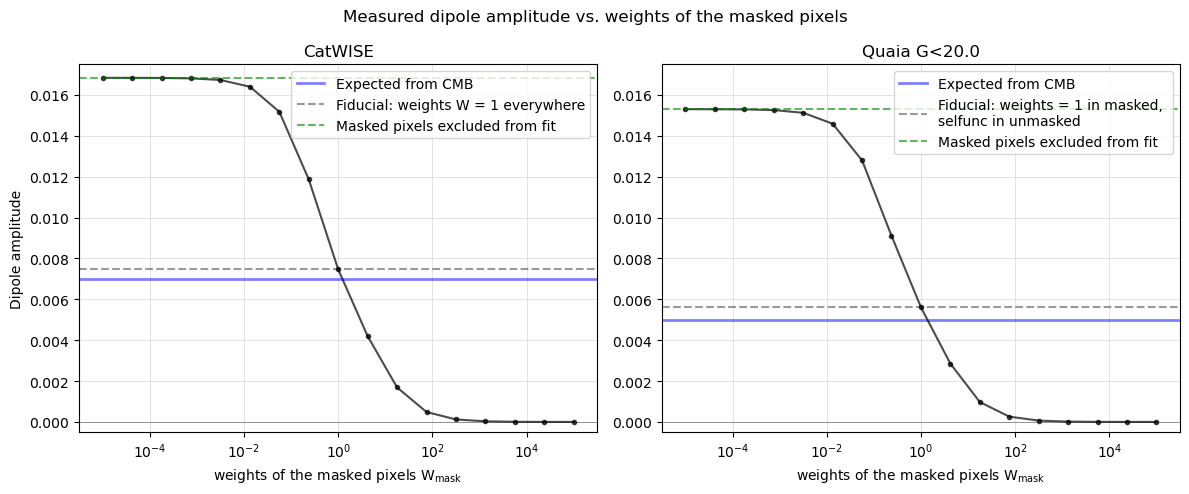

In [13]:
# plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5), tight_layout=True)

# the expected amplitude
ax0.axhline(cmb_dipamp_catwise, c='b', alpha=0.5, lw=2, label='Expected from CMB')
# the measured amplitudes as a function of variance of the masked pixels
ax0.plot(Cinvs, measured_dipamps_catwise, marker='.', ms=6, c='k', alpha=0.7)
# highlight the fiducial measurement (when Cinv=identity everywhere)
ax0.axhline(measured_dipamps_catwise[Cinvs==1.], c='k', ls='--', alpha=0.4,
            label='Fiducial: weights W = 1 everywhere')
# and the measured amplitude when we don't fit masked pixels at all
ax0.axhline(dipamp_catwise_noreg, c='g', ls='--', alpha=0.6, label='Masked pixels excluded from fit')
ax0.set_ylabel('Dipole amplitude')
ax0.set_title('CatWISE')

# the expected amplitude
ax1.axhline(cmb_dipamp_quaia, c='b', alpha=0.5, lw=2, label='Expected from CMB')
# the measured amplitudes as a function of variance of the masked pixels
ax1.plot(Cinvs, measured_dipamps_quaia, marker='.', ms=6, c='k', alpha=0.7)
# highlight the fiducial measurement (when Cinv=identity in masked, completeness in unmasked)
ax1.axhline(measured_dipamps_quaia[Cinvs==1.], c='k', ls='--', alpha=0.4,
            label=f'Fiducial: weights = 1 in masked, \nselfunc in unmasked')
# and the measured amplitude when we don't fit masked pixels at all
ax1.axhline(dipamp_quaia_noreg, c='g', ls='--', alpha=0.6, label='Masked pixels excluded from fit')
ax1.set_title('Quaia G<20.0')

for ax in [ax0, ax1]:
    ax.set_ylim(-.0005, .0175)
    ax.axhline(0, c='k', alpha=0.5, lw=0.5)
    ax.semilogx()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel(r'weights of the masked pixels W$_\mathrm{mask}$')
    ax.legend(loc=1)
fig.suptitle('Measured dipole amplitude vs. weights of the masked pixels')

### fit up to some $\ell_\mathrm{max}$ and reconstruct the maps

In [14]:
# maps to fit
map_to_fit_catwise = overdensity_map_catwise.copy()
idx_masked_catwise = np.isnan(map_to_fit_catwise)
map_to_fit_catwise[idx_masked_catwise] = 0.

map_to_fit_quaia = overdensity_map_quaia.copy()
idx_masked_quaia = np.isnan(map_to_fit_quaia)
map_to_fit_quaia[idx_masked_quaia] = 0.

In [15]:
# expected dipole direction
cmb_dipamp, cmb_dipdir = dipole.cmb_dipole()

In [16]:
# choose Cinvs (fewer than above since this fit takes longer)
Cinvs = [0, .03, 0.1, 0.3, 1., 3.] # np.logspace(-1,2,7)

In [17]:
# choose max ells
max_ells = [1, 2, 5, 10]

In [16]:
# perform the fits
assert False

# fig = plt.figure(figsize=(4 * len(max_ells), 3 * len(Cinvs)))

kwargs = dict(coord=['C','G'], min=-.03, max=.03, fig=fig, cmap='RdBu', graticule=True)

reconstructed_maps = np.empty((len(max_ells), len(Cinvs), hp.nside2npix(NSIDE)))
dipdirs = []

# loop through our max_ells
for j, max_ell in enumerate(max_ells):
    
    dipdirs_ = []
    
    # loop through our Cinvs
    for i, Cinv in enumerate(Cinvs):
        end = '\n' if i==len(Cinvs)-1 else '\r'
        print(f'{max_ell}: {i+1} of {len(Cinvs)}', end=end)

        # CATWISE
        # Cinv: identity in unmasked pixels, this Cinv in the masked pixels
        Cinv_ = np.ones_like(map_to_fit_catwise)
        Cinv_[idx_masked_catwise] = Cinv
        ells, Cells_catwise, alms = Cells_from_alms_fit(map_to_fit_catwise, Cinv_, max_ell, return_alms=True)
        reconstructed_catwise = reconstruct_map(alms, NSIDE=NSIDE)
        reconstructed_maps[j,i] = reconstructed_catwise
        # get dipole direction: need to insert a 1 monopole since we're fitting overdensities
        dipdir_catwise = dipole.get_dipole(np.append(1,[alms[3],alms[1],alms[2]]))[1]
        dipdirs_.append(dipdir_catwise)
        
        # hp.projview(reconstructed_catwise, sub=(len(Cinvs), len(max_ells), len(max_ells)*i+j+1),
        #             title=r'$\ell_\mathrm{max}=$'f'{max_ell}, Cinv={Cinv:.1e}', **kwargs)
        # tools.plot_marker(dipdir_catwise.galactic.l, dipdir_catwise.galactic.b,
        #                   marker='*', c='w', mec='k', lw=0.5, ms=8)
        # tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
        #                   marker='*', c='k', ms=8, alpha=0.8)
        # tools.label_coord(plt.gca(), 'Galactic')
    
    dipdirs.append(dipdirs_)

# fig.suptitle('Reconstructed CatWISE')

1: 6 of 6
2: 6 of 6
5: 6 of 6
10: 6 of 6


In [17]:
save_info = dict(max_ells=max_ells, Cinvs=Cinvs, reconstructed_maps=reconstructed_maps, dipdirs=dipdirs)
np.save('reconstructed_catwise_maps.npy', save_info)

In [18]:
res = np.load('reconstructed_catwise_maps.npy', allow_pickle=True).item()
max_ells = res['max_ells']
Cinvs = res['Cinvs']
reconstructed_maps = res['reconstructed_maps']
dipdirs = res['dipdirs']

In [19]:
# expected dipole direction
cmb_dipamp, cmb_dipdir = dipole.cmb_dipole()

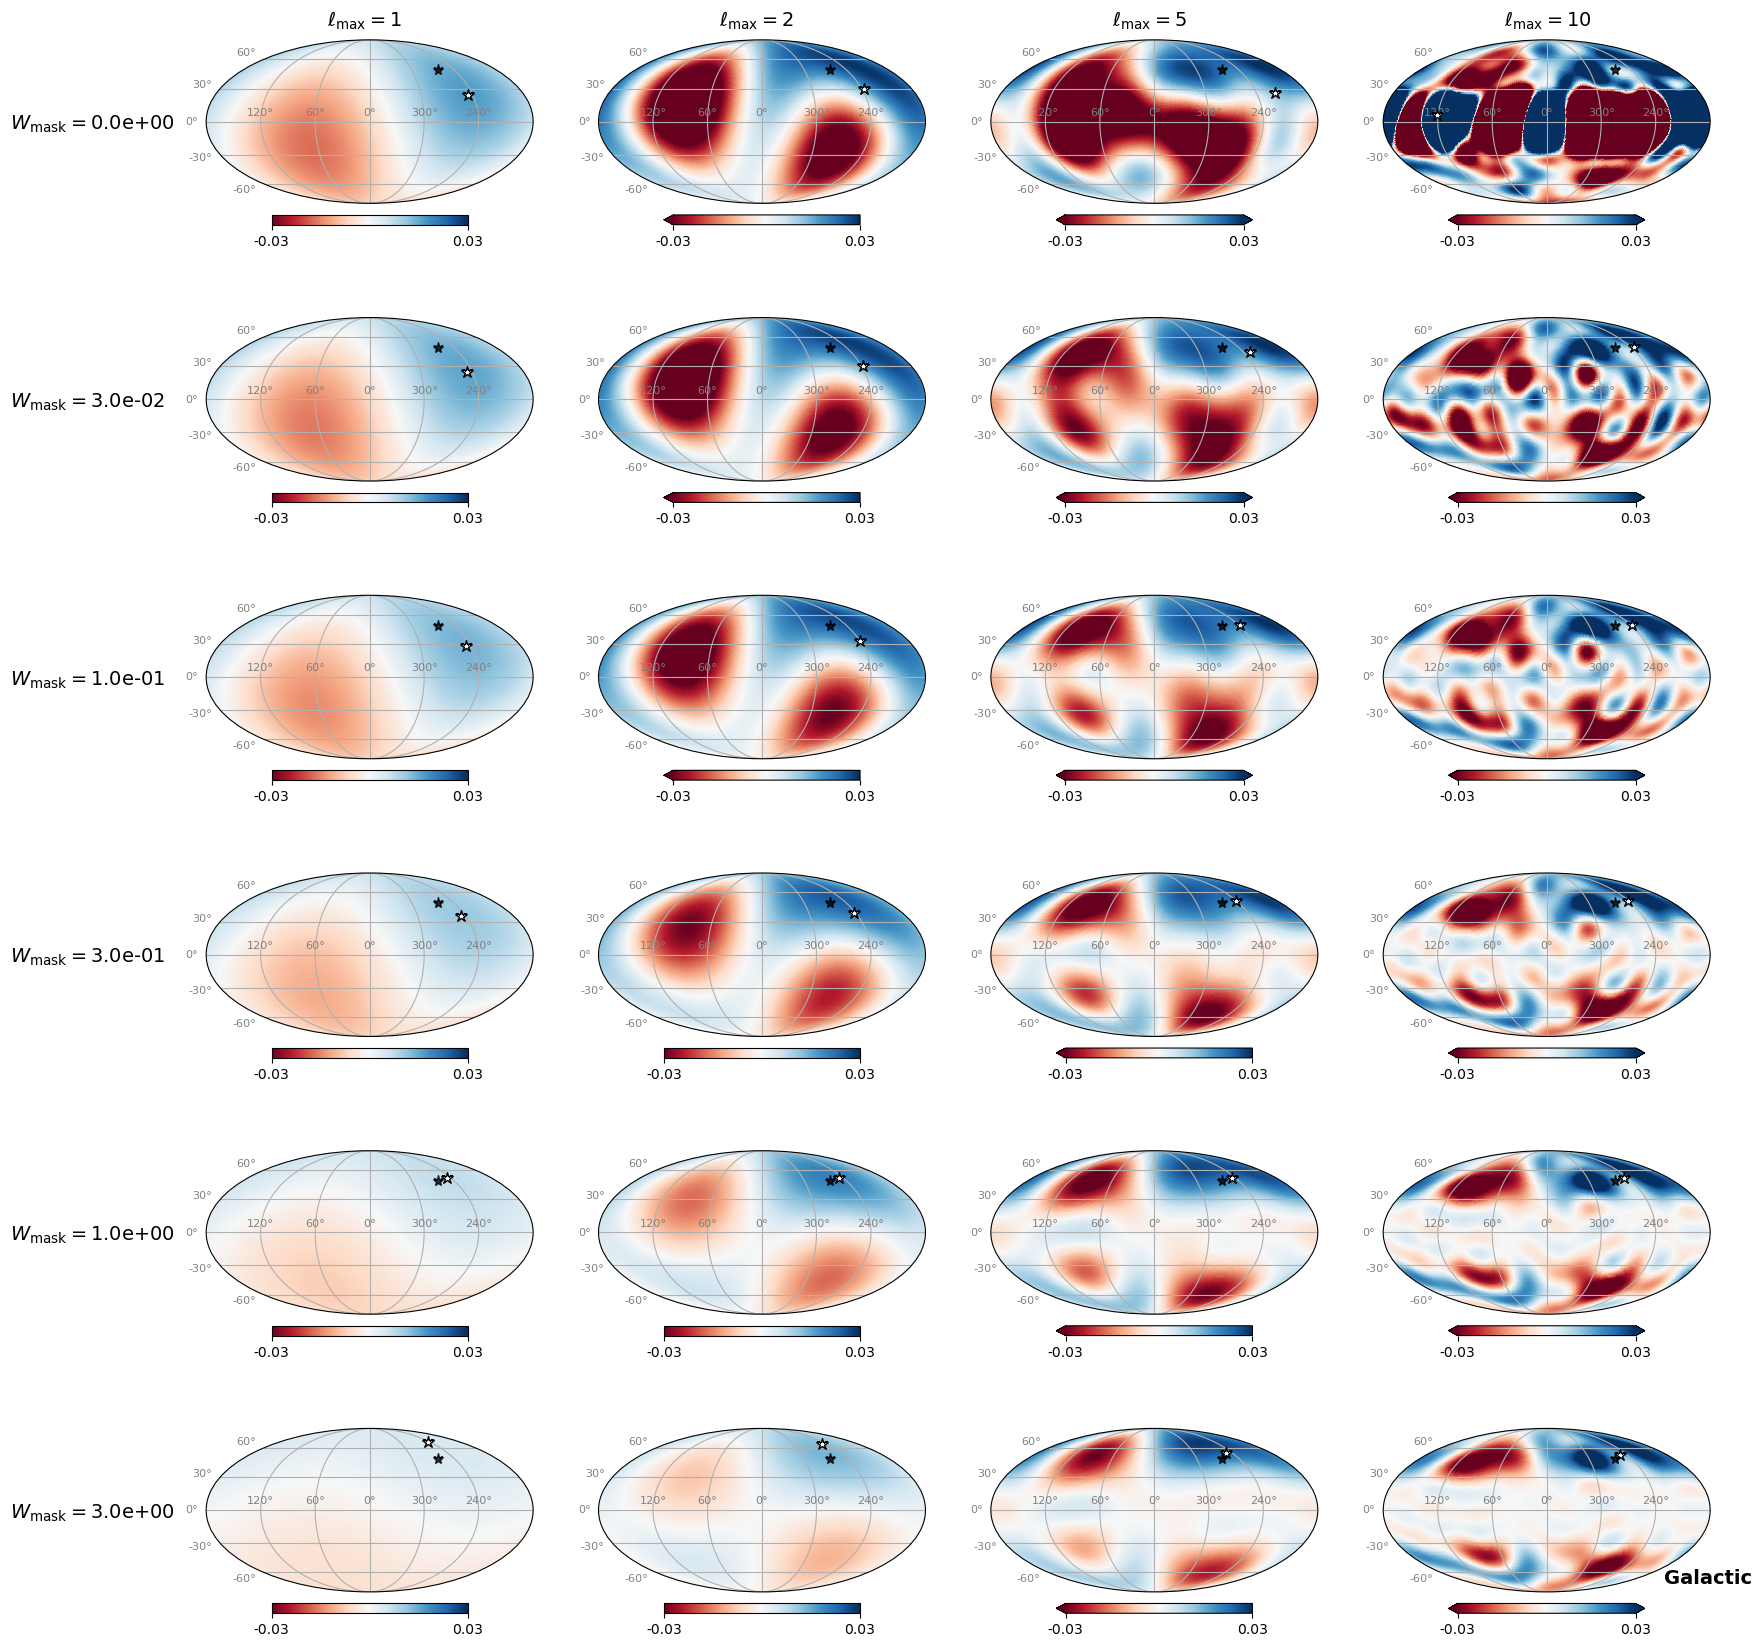

In [20]:
# plott
fig = plt.figure(figsize=(4 * len(max_ells), 3 * len(Cinvs)))

kwargs = dict(coord=['C','G'], min=-.03, max=.03, fig=fig, cmap='RdBu',
              graticule=True, graticule_labels=True, xtick_label_color='grey', ytick_label_color='grey',
             fontsize={'xtick_label':8, 'ytick_label':8})

for j, max_ell in enumerate(max_ells):
    for i, Cinv in enumerate(Cinvs):
        hp.projview(reconstructed_maps[j,i], sub=(len(Cinvs), len(max_ells), len(max_ells)*i+j+1),
                    title='', **kwargs) # r'$\ell_\mathrm{max}=$'f'{max_ell}, Cinv={Cinv:.1e}'
        ax = plt.gca()
        tools.plot_marker(dipdirs[j][i].galactic.l, dipdirs[j][i].galactic.b,
                          marker='*', c='w', mec='k', lw=0.5, ms=9)
        tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
                          marker='*', c='k', ms=8, alpha=0.8)
        if i == 0:
            ax.text(0.37, 1.08, r'$\ell_\mathrm{max}=$'f'{max_ell}',
                           fontdict={'size':14}, transform=ax.transAxes)
        if j == 0:
            ax.text(-0.6, 0.45, r'$W_\mathrm{mask}=$'f'{Cinv:.1e}',
                    fontdict={'size':14}, transform=ax.transAxes)
        if j == len(max_ells)-1 and i == len(Cinvs)-1:
            tools.label_coord(ax, 'Galactic')

# fig.suptitle('Reconstructed CatWISE')

In [19]:
# perform the fits

# fig = plt.figure(figsize=(4 * len(max_ells), 3 * len(Cinvs)))

kwargs = dict(coord=['C','G'], min=-.03, max=.03, fig=fig, cmap='RdBu', graticule=True)

reconstructed_maps = np.empty((len(max_ells), len(Cinvs), hp.nside2npix(NSIDE)))
dipdirs = []

# loop through our max_ells
for j, max_ell in enumerate(max_ells):
    
    dipdirs_ = []
    
    # loop through our Cinvs
    for i, Cinv in enumerate(Cinvs):
        end = '\n' if i==len(Cinvs)-1 else '\r'
        print(f'{max_ell}: {i+1} of {len(Cinvs)}', end=end)

        # CATWISE
        # Cinv: identity in unmasked pixels, this Cinv in the masked pixels
        Cinv_ = selfunc.copy()
        Cinv_[idx_masked_quaia] = Cinv
        ells, Cells_quaia, alms = Cells_from_alms_fit(map_to_fit_quaia, Cinv_, max_ell, return_alms=True)
        reconstructed_quaia = reconstruct_map(alms, NSIDE=NSIDE)
        reconstructed_maps[j,i] = reconstructed_quaia
        # get dipole direction: need to insert a 1 monopole since we're fitting overdensities
        dipdir_quaia = dipole.get_dipole(np.append(1,[alms[3],alms[1],alms[2]]))[1]
        dipdirs_.append(dipdir_quaia)
        
        # hp.projview(reconstructed_catwise, sub=(len(Cinvs), len(max_ells), len(max_ells)*i+j+1),
        #             title=r'$\ell_\mathrm{max}=$'f'{max_ell}, Cinv={Cinv:.1e}', **kwargs)
        # tools.plot_marker(dipdir_catwise.galactic.l, dipdir_catwise.galactic.b,
        #                   marker='*', c='w', mec='k', lw=0.5, ms=8)
        # tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
        #                   marker='*', c='k', ms=8, alpha=0.8)
        # tools.label_coord(plt.gca(), 'Galactic')
    
    dipdirs.append(dipdirs_)

# fig.suptitle('Reconstructed CatWISE')

1: 6 of 6
2: 6 of 6
5: 6 of 6
10: 6 of 6


In [20]:
save_info = dict(max_ells=max_ells, Cinvs=Cinvs, reconstructed_maps=reconstructed_maps, dipdirs=dipdirs)
np.save('reconstructed_quaia_maps.npy', save_info)

In [20]:
# load Quaia
res = np.load('reconstructed_quaia_maps.npy', allow_pickle=True).item()
max_ells = res['max_ells']
Cinvs = res['Cinvs']
reconstructed_maps = res['reconstructed_maps']
dipdirs = res['dipdirs']

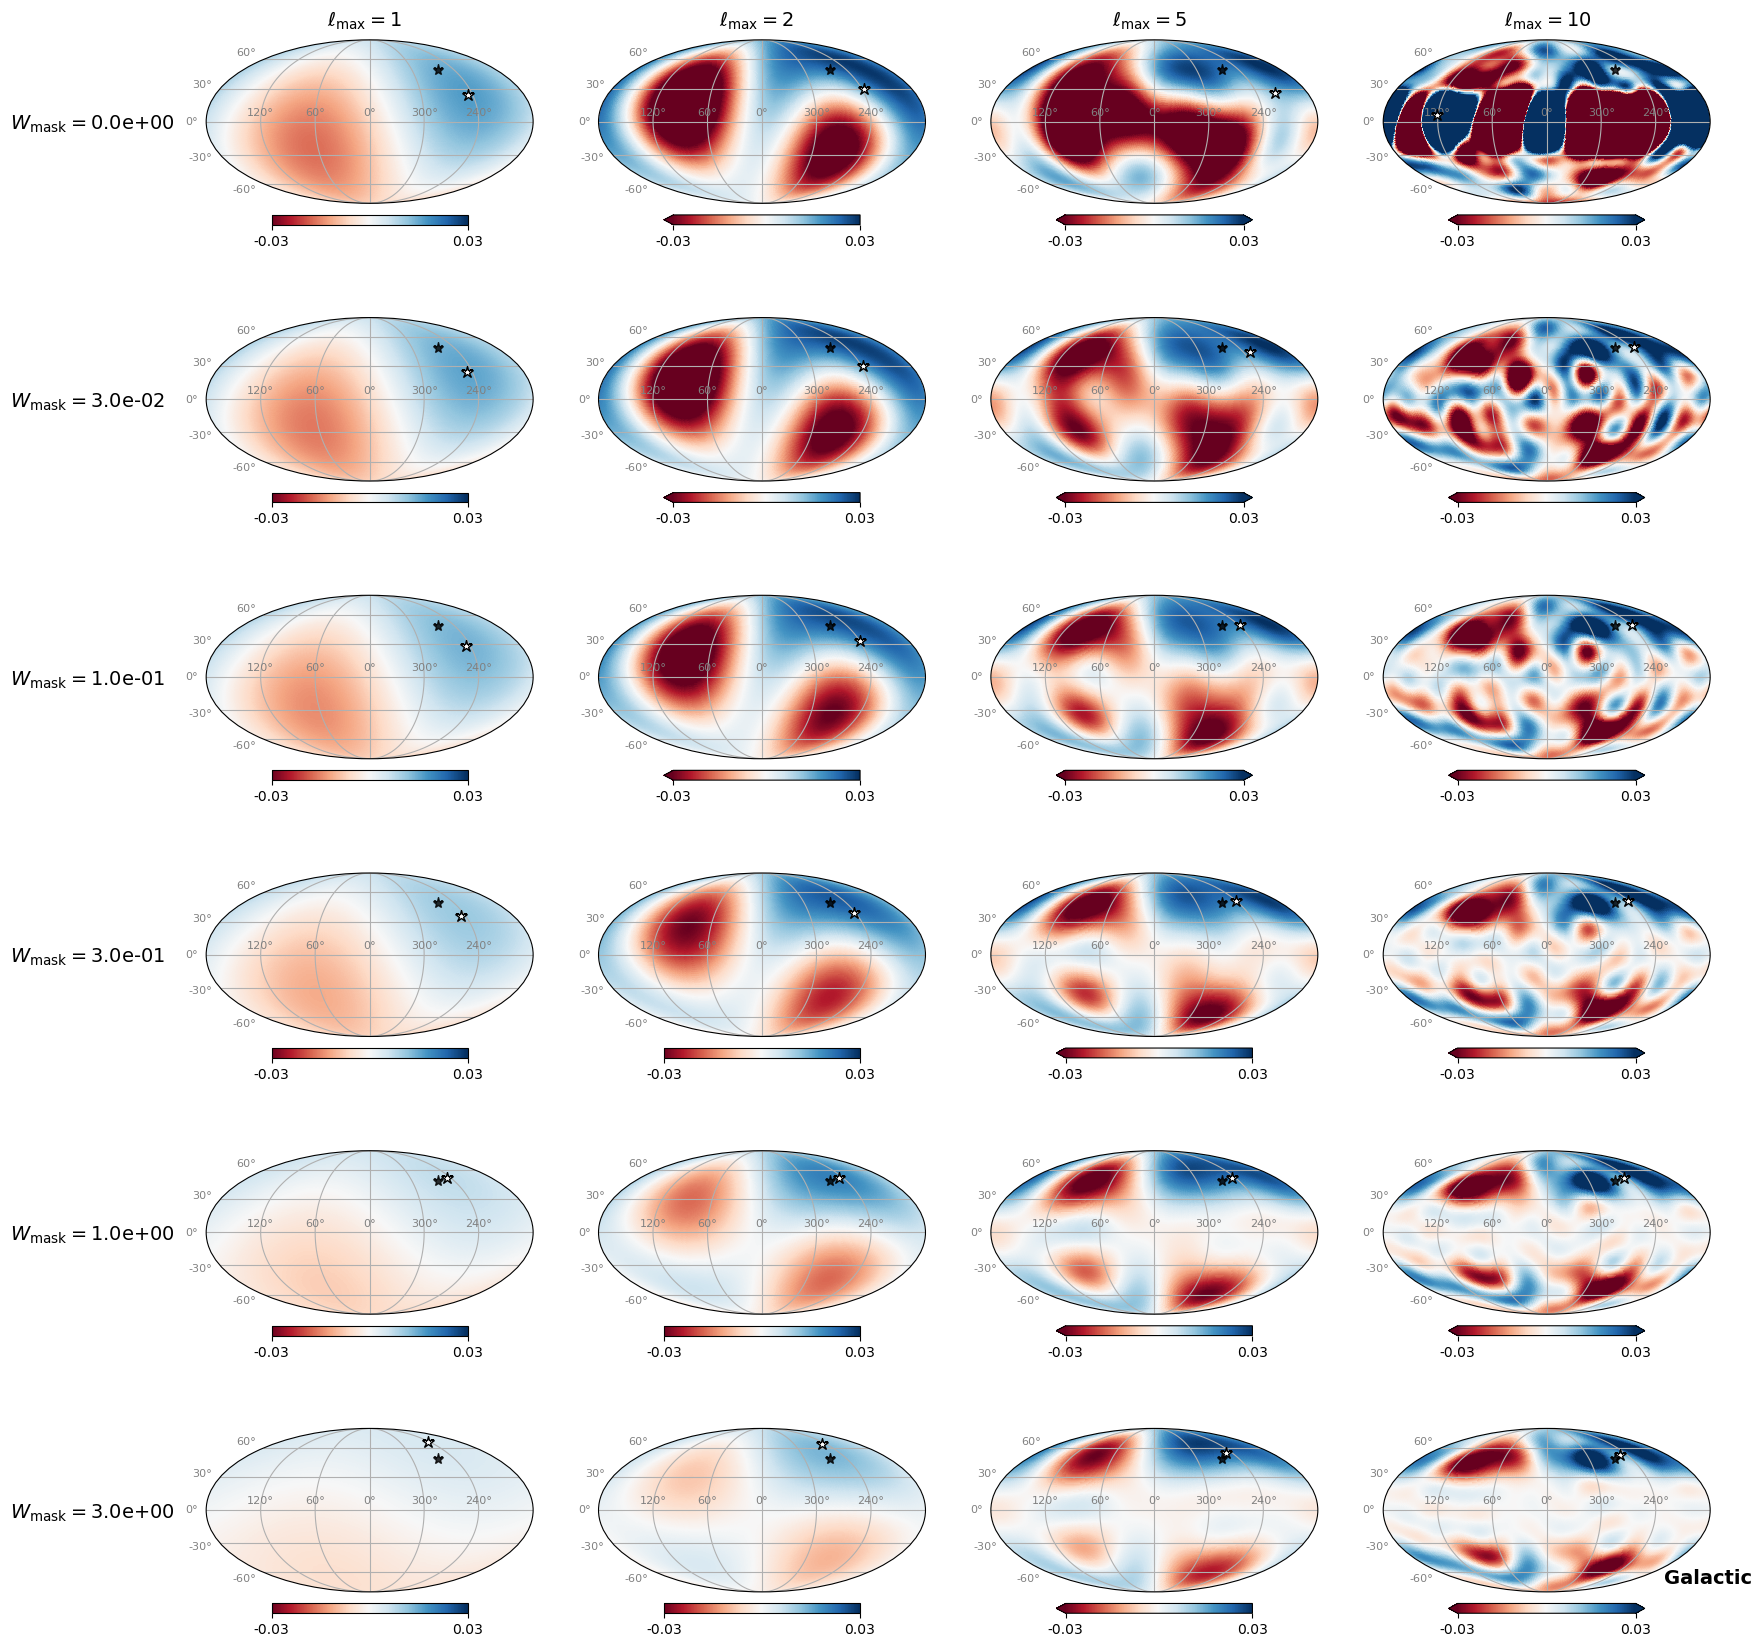

In [23]:
# plott Quaia
fig = plt.figure(figsize=(4 * len(max_ells), 3 * len(Cinvs)))

kwargs = dict(coord=['C','G'], min=-.03, max=.03, fig=fig, cmap='RdBu',
              graticule=True, graticule_labels=True, xtick_label_color='grey', ytick_label_color='grey',
             fontsize={'xtick_label':8, 'ytick_label':8})

for j, max_ell in enumerate(max_ells):
    for i, Cinv in enumerate(Cinvs):
        hp.projview(reconstructed_maps[j,i], sub=(len(Cinvs), len(max_ells), len(max_ells)*i+j+1),
                    title='', **kwargs) # r'$\ell_\mathrm{max}=$'f'{max_ell}, Cinv={Cinv:.1e}'
        ax = plt.gca()
        tools.plot_marker(dipdirs[j][i].galactic.l, dipdirs[j][i].galactic.b,
                          marker='*', c='w', mec='k', lw=0.5, ms=9)
        tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
                          marker='*', c='k', ms=8, alpha=0.8)
        if i == 0:
            ax.text(0.37, 1.08, r'$\ell_\mathrm{max}=$'f'{max_ell}',
                           fontdict={'size':14}, transform=ax.transAxes)
        if j == 0:
            ax.text(-0.6, 0.45, r'$W_\mathrm{mask}=$'f'{Cinv:.1e}',
                    fontdict={'size':14}, transform=ax.transAxes)
        if j == len(max_ells)-1 and i == len(Cinvs)-1:
            tools.label_coord(ax, 'Galactic')

# fig.suptitle('Reconstructed CatWISE')

In [17]:
# load in best-fit model from David
with np.load('/scratch/aew492/quasars/quaia_PS/cl_gg_bf_G20.0_1bin.npz') as res:
    ell = res['ell']
    cl_gg = res['cl_gg']

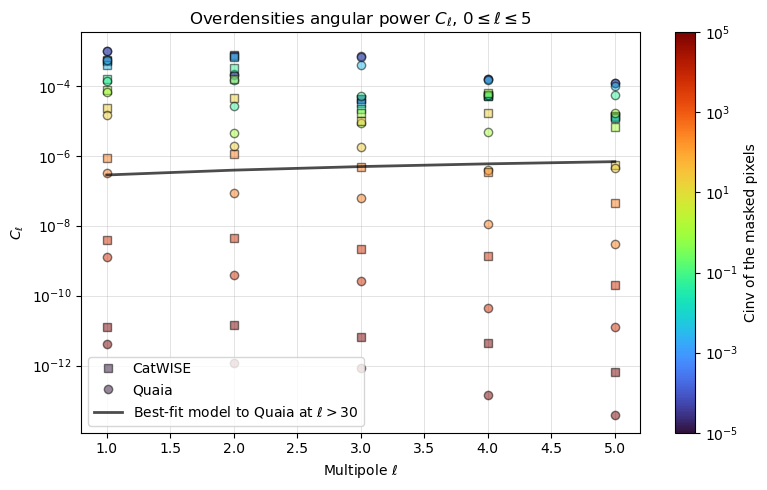

In [18]:
# plottt
norm = mpl.colors.LogNorm(vmin=min(Cinvs), vmax=max(Cinvs))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
kwargs = dict(ls='None', alpha=0.5, mec='k')
for i, Cinv in enumerate(Cinvs):
    ells = np.arange(max_ell+1)
    label = 'CatWISE' if i==0 else ''
    ax.plot(ells[1:], Cells_catwise[i][1:], marker='s', label=label, c=smap.to_rgba(Cinv), **kwargs)
    label = 'Quaia' if i==0 else ''
    ax.plot(ells[1:], Cells_quaia[i][1:], marker='o', label=label, c=smap.to_rgba(Cinv), **kwargs)

idx = (ell <= max_ell)
ax.plot(ell[idx], cl_gg[idx], c='k', alpha=0.7, lw=2, label=r'Best-fit model to Quaia at $\ell>30$')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
fig.colorbar(smap, ax=ax, label='Cinv of the masked pixels')
ax.legend()

### check out the dipole / $C_\ell$ as a function of $f_\mathrm{sky}$

In [19]:
# remake Quaia overdensity map, without masking the galactic plane

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=0, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False)
d = SecrestDipole(**quaia_kwargs)
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)
mean, std = np.nanmean(datamap), np.nanstd(datamap)

# delete the tables to clear up memory !
del d.initial_cattab
del d.table

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == hp.nside2npix(NSIDE)
mask = small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

# GET OVERDENSITIES
# mean density of the map: mean of the _expected_ counts
mean_density = np.nanmean(masked_datamap[selfunc>0] / selfunc[selfunc>0])

# then the overdensity map is
overdensity_map_quaia_nogalcut = np.divide(masked_datamap, selfunc, where=(selfunc>0),
                            out=np.full_like(masked_datamap, np.nan)) / mean_density - 1
                    # (fancy divide to avoid RuntimeWarnings where completeness goes to zero)

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.


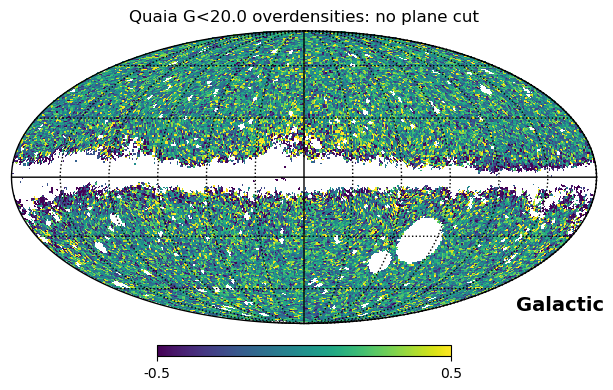

In [20]:
# plot
fig = plt.figure(figsize=(12,4))
hp.mollview(overdensity_map_quaia_nogalcut, min=-.5, max=.5, coord=['C','G'], badcolor='w',
            title=f'Quaia G<{d.maglim} overdensities: no plane cut', fig=fig, sub=(1,2,1))
hp.graticule()

min. completeness:  [0.         0.10467759 0.19839777 0.28230756 0.35743387 0.42469614
 0.48491756 0.53883515 0.58710877 0.63032923 0.66902547 0.70367109
 0.73469008 0.76246208 0.78732698]
0.000 -> 	40786 pixels
0.105 -> 	38971 pixels
0.198 -> 	37104 pixels
0.282 -> 	35418 pixels
0.357 -> 	33436 pixels
0.425 -> 	31194 pixels
0.485 -> 	28618 pixels
0.539 -> 	25633 pixels
0.587 -> 	21914 pixels
0.630 -> 	17407 pixels
0.669 -> 	11920 pixels
0.704 -> 	5123 pixels
0.735 -> 	341 pixels
0.762 -> 	4 pixels
0.787 -> 	1 pixels


Text(0.5, 0.98, 'Quaia maps to fit, based on min. completeness')

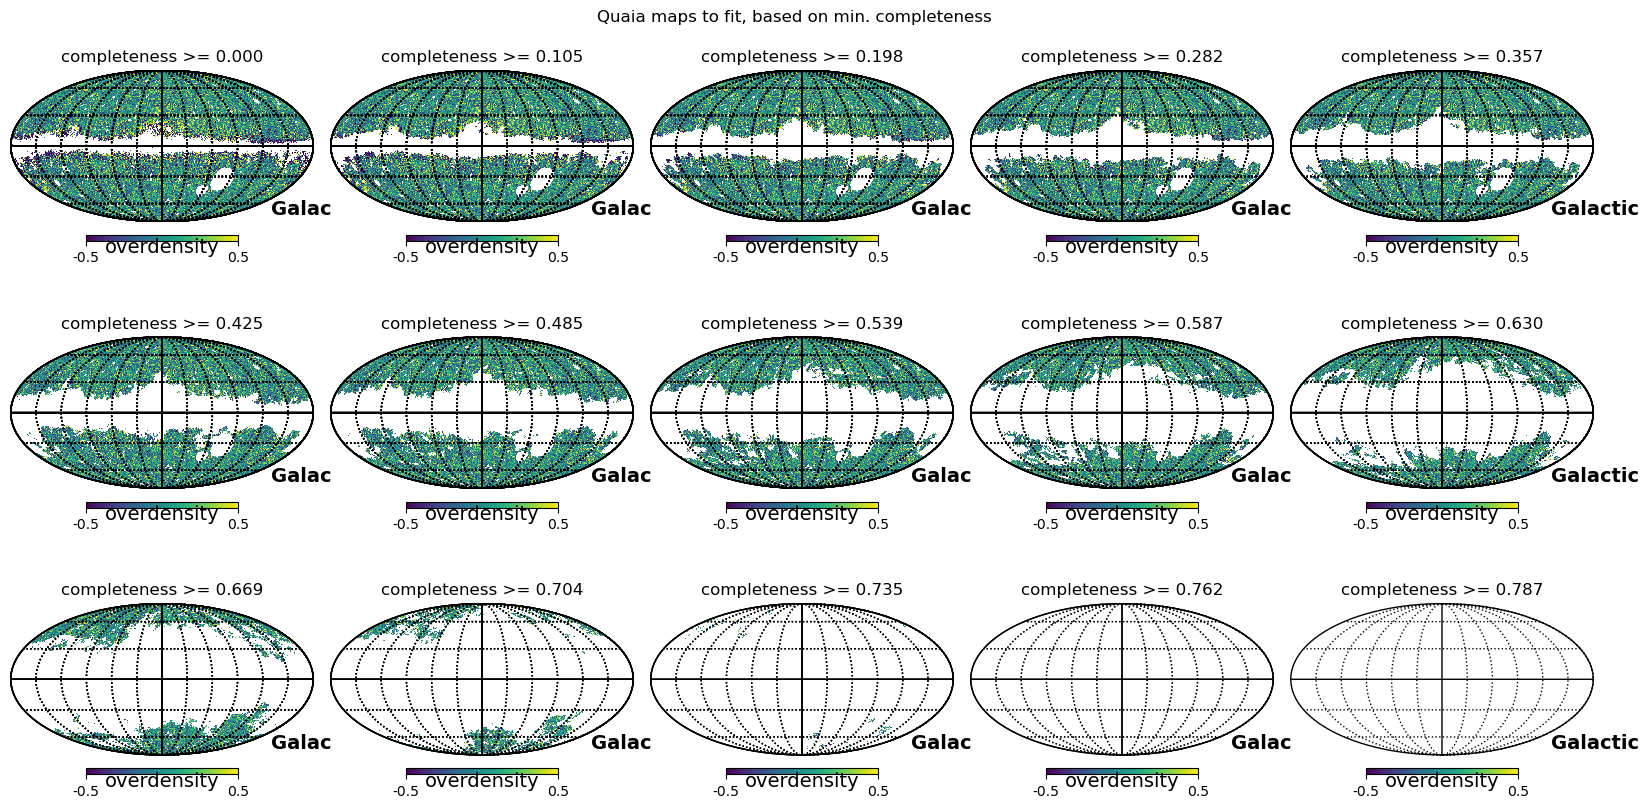

In [22]:
# Quaia: use pixel completeness
min_completenesss = 1 - np.logspace(np.log10(1-np.amax(selfunc)), 0, 15)
# min_completenesss = np.linspace(0, np.amax(selfunc), 11)
min_completenesss.sort()
print(f"min. completeness: ", min_completenesss)

# perform the fits: keep the same max_ell as above; use the (current) "fiducial" Cinv cases

# empty arrays to store the results
Cells_quaia_fsky = np.empty((len(min_completenesss), max_ell+1))
reconstructed_quaias_fsky = np.empty((len(min_completenesss), hp.nside2npix(NSIDE)))

fig = plt.figure(figsize=(16,8))

# loop through our minimum completenesses
for i, min_comp in enumerate(min_completenesss):

    # idx to mask: where selfunc >= min completeness, and where pixels are NaN (i.e. where selfunc==0)
    idx_unmasked = (selfunc >= min_comp) & ~np.isnan(overdensity_map_quaia_nogalcut)
    print(f"{min_comp:.3f} -> \t{np.sum(idx_unmasked)} pixels")
    
    # set masked pixels to zero counts
    map_to_fit = overdensity_map_quaia_nogalcut.copy()
    map_to_fit[~idx_unmasked] = 0.
    
    # plot
    map_to_plot = map_to_fit.copy()
    map_to_plot[~idx_unmasked] = np.nan
    hp.mollview(map_to_plot, coord=['C','G'], min=-.5, max=.5, sub=(3,5,i+1), badcolor='w',
                  title=f'completeness >= {min_comp:.3f}', fig=fig, unit='overdensity')
    hp.graticule()
    
    # for Quaia, Cinv is completeness in unmasked pixels, 1 in the masked pixels
    Cinv_ = selfunc.copy()
    Cinv_[~idx_unmasked] = 1.
    
    ells, Cells_quaia_fsky[i], alms = Cells_from_alms_fit(map_to_fit, Cinv_, max_ell, return_alms=True)
    reconstructed_quaias_fsky[i] = reconstruct_map(alms, NSIDE=NSIDE)
fig.suptitle('Quaia maps to fit, based on min. completeness')

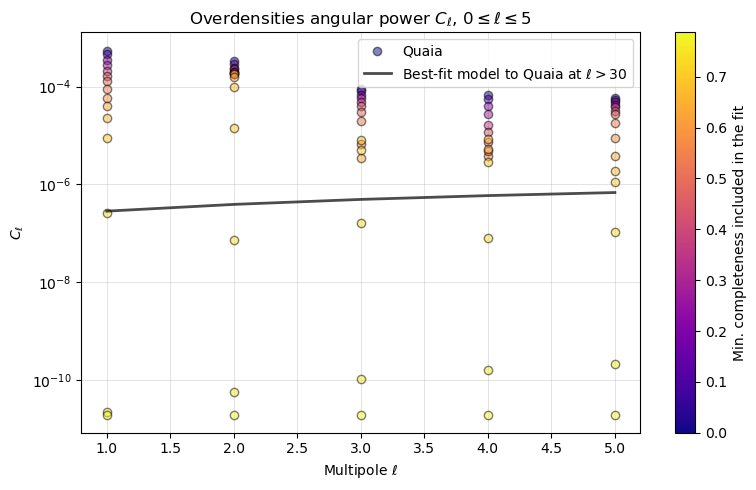

In [23]:
# plottt
norm = mpl.colors.Normalize(vmin=min(min_completenesss), vmax=max(min_completenesss))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='plasma')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
kwargs = dict(ls='None', alpha=0.5, mec='k')
for i, min_comp in enumerate(min_completenesss):
    ells = np.arange(max_ell+1)
    label = 'Quaia' if i==0 else ''
    ax.plot(ells[1:], Cells_quaia_fsky[i][1:], marker='o', label=label, c=smap.to_rgba(min_comp), **kwargs)

idx = (ell <= max_ell)
ax.plot(ell[idx], cl_gg[idx], c='k', alpha=0.7, lw=2, label=r'Best-fit model to Quaia at $\ell>30$')
ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'Overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
fig.colorbar(smap, ax=ax, label='Min. completeness included in the fit')
ax.legend()

Text(0.5, 1.02, 'Reconstructed Quaia')

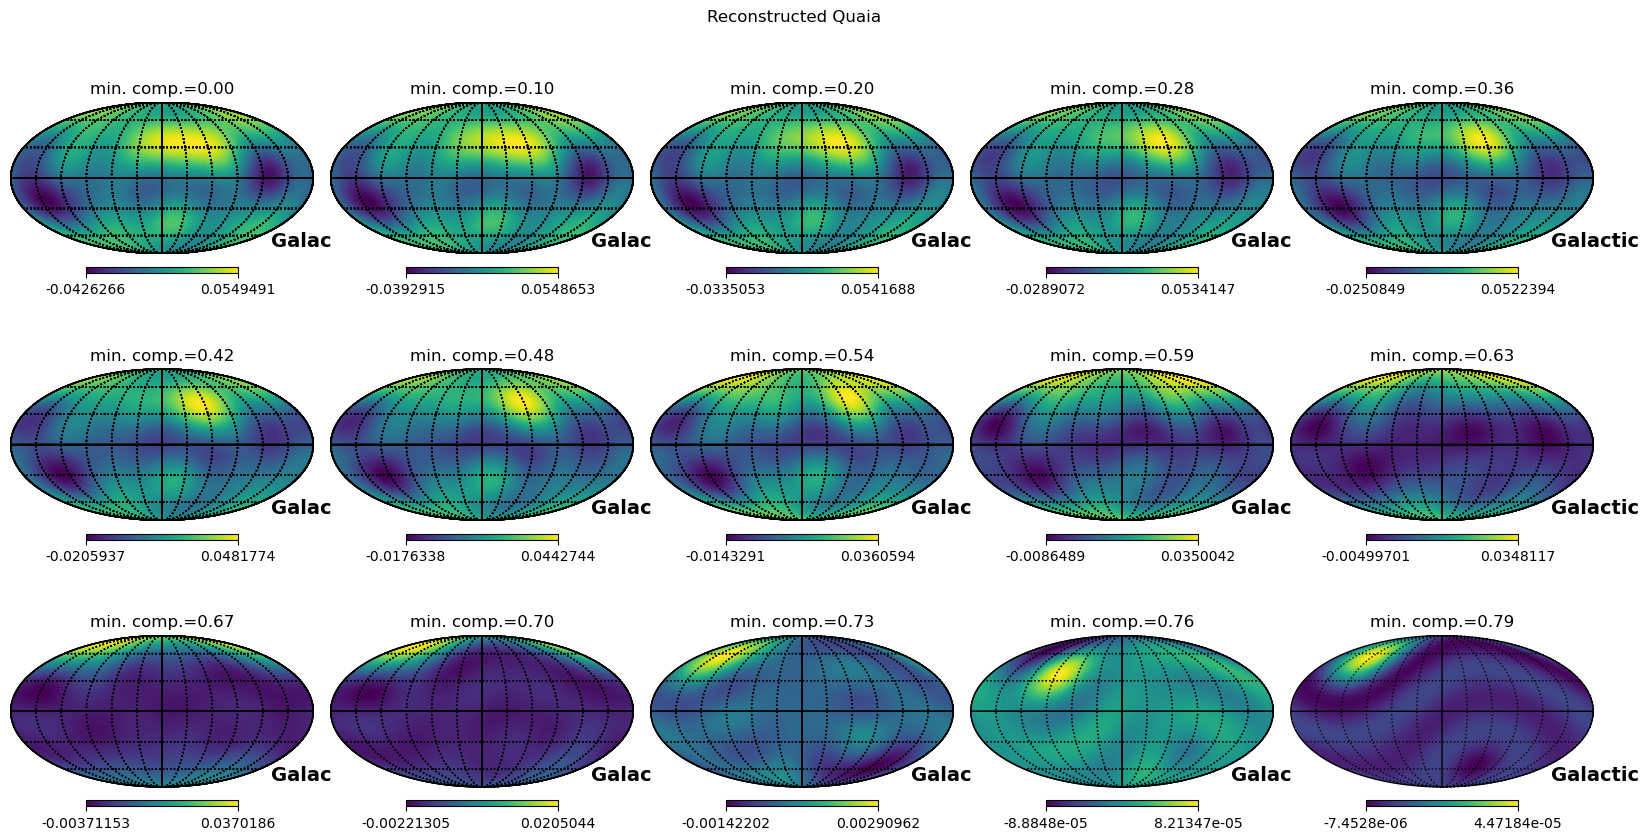

In [24]:
# plottt the reconstructed maps: Quaia
fig = plt.figure(figsize=(16,8))
for i, min_comp in enumerate(min_completenesss):
    kwargs = dict(coord=['C','G'], sub=(3,5,i+1),
                  title=f'min. comp.={min_comp:.2f}', fig=fig)
    hp.mollview(reconstructed_quaias_fsky[i], **kwargs)
    hp.graticule()
fig.suptitle('Reconstructed Quaia', y=1.02)